# Get g-memberships from two k-distributions using g-thresholds that have been used in lblnew.f

In [1]:
%matplotlib inline
from IPython import display
import os, sys

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib 
import matplotlib.pyplot as plt

In [2]:
matplotlib.rc('font', size=13)

# O3 band 5 absorption coefficient

In [3]:
# for loading absorption coefficient calculated using line-by-line
# k(v, pt)

def get_data_file_paths():
    
    dir_common = os.path.join('/nuwa_cluster/home/jackyu',
                              'radiation/crd/LW/examples',
                              'separate_g_groups',
                              'study__lblnew_g1_threshold',
                              'o3',
                              'band05_wn_980_1100',
                              'P_1_T_250_min_2e-22_max_5e-17_ng_20_dlogN_uniform__P_50_T_250',
                              'ighigh_7',
                              'wgt_1_1_1_1_1_1_1_.7_.7_.7_.7_.7_.7_.7_.7_.7_.7_.7_.7',
                              'midlatitude_summer',
                              'onetime_version')
    
    dir_runs = ['']
    
    path_runs = [os.path.join(dir_common, dir_run, 'output_abshl.dat')
                 for dir_run in dir_runs]
    return path_runs



def load_absgas_file(path_absgas):
    df = pd.read_csv(path_absgas, sep=r'\s+')
    df = df.set_index(['v', 'pressure', 'temperature'])
    
    ds = xr.Dataset.from_dataframe(df)
    ds = ds.stack(pt=('pressure', 'temperature'))
    ds.coords['ipt'] = ('pt', range(1, ds.dims['pt'] + 1))
    return ds   
    

    
def load_absgas_files(paths_absgas):
    dss = [load_absgas_file(fpath) for fpath in paths_absgas]
    return xr.concat(dss, dim='pt')



def o3_band5_limits():
    return {'min': 980, 'max': 1100}



def ref_pts():
    return {'low': (50, 250), 'high': (1, 250)}




def get_tworef_dataframe(ds, min_wvn=0, max_wvn=3000, pts=None):
    if pts == None:
        pts = [(50, 250)]
        
    pts = sorted([pt for _, pt in ref_pts().items()],
                 key=lambda x: x[0])
    return ds['absgas'].sel(pt=pts, v=slice(min_wvn, max_wvn))\
           .to_pandas()


In [4]:
ds = load_absgas_files(get_data_file_paths())

In [5]:
vlims = o3_band5_limits()
pts = [pt for _, pt in ref_pts().items()]

df = get_tworef_dataframe(ds, 
                          min_wvn=vlims['min'],
                          max_wvn=vlims['max'],
                          pts=pts)

In [6]:
df.head()

pressure,1,50
temperature,250,250
v,,
980.001,1.852463e-20,5.806543e-21
980.003,3.134201e-22,4.071877e-21
980.005,8.245442e-23,2.557286e-21
980.007,4.312231e-23,1.698846e-21
980.009,2.852815e-23,1.243706e-21


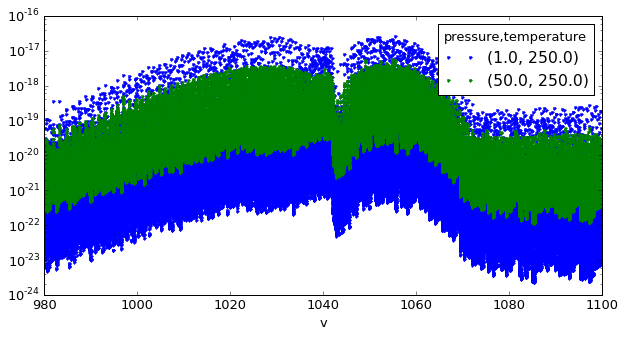

In [7]:
# have a look at the k at the two reference pt's.
df.plot(logy=True, figsize=(10, 5),
        linestyle='None', marker='.')

# Sorting k

In [8]:
def get_absth():
    '''
    These are the absth values specified in lblnew.f
    '''
    return {'high': np.array([2.0000000e-22, 3.84708783e-22, 
                              7.40004238e-22, 1.42343065e-21, 
                              2.73803136e-21, 5.26672357e-21,
                              1.01307741e-20, 1.94869888e-20,
                              3.74840787e-20, 7.21022715e-20, 
                              1.38691886e-19, 2.66779933e-19,
                              5.13162916e-19, 9.87091404e-19,  
                              1.89871366e-18, 3.65225911e-18,  
                              7.02528079e-18, 1.35134361e-17,
                              2.59936878e-17, 5.00000000e-17]),
            'low': np.array([1.000e-20, 1.387e-20,   
                             1.924e-20, 2.668e-20, 
                             3.700e-20, 5.132e-20,
                             7.117e-20, 9.871e-20,  
                             1.369e-19, 1.899e-19,   
                             2.633e-19, 3.652e-19,
                             5.065e-19, 7.025e-19, 
                             9.743e-19, 1.351e-18,  
                             1.874e-18, 2.599e-18,
                             3.605e-18, 5.000e-18])}



def value_bins(absth):
    return np.concatenate(([0], absth[1:-1], [1]), axis=0)


def g_high_inclusive():
    "the lowest g that is from sorting k at pt_high"
    return 8


def ng_tot():
    return 20


def find_ggroup_membership(kdist, absth):
    '''
    Map each spectral point (or wavenumber) to a g-group,
    based on the distribution of k and the g-groups, defined
    by their upper and lower limits.
    '''
    bins = value_bins(absth)
    ng = len(absth) - 1

    return pd.cut(kdist, bins=bins, 
                  labels=range(1, ng + 1), 
                  right=False,
                  include_lowest=True,
                  retbins=True)

In [9]:
# sort using the high reference

srs = df[ref_pts()['high']]

absth_high = np.concatenate(([0], get_absth()['high']), axis=0)

ncut_high = find_ggroup_membership(srs, absth_high)

grouped_high = srs.groupby(ncut_high[0])


print('fractional size of g-groups')
grouped_high.size() / grouped_high.size().sum()

fractional size of g-groups


(1.0, 250.0)
1     0.246517
2     0.078933
3     0.092667
4     0.103733
5     0.100367
6     0.090033
7     0.073767
8     0.058833
9     0.046683
10    0.033833
11    0.023367
12    0.014983
13    0.009250
14    0.006783
15    0.005950
16    0.005117
17    0.004383
18    0.003150
19    0.001633
20    0.000017
dtype: float64

In [10]:
# get the spectral points that are in g-groups 1 ~ 7

wvns_low = ncut_high[0][ncut_high[0] <= g_high_inclusive() - 1]

In [11]:
# sort at low reference at these leftover spectral points

ng_low = g_high_inclusive() - 1
srs = df[ref_pts()['low']][wvns_low.index]

#absth_low = np.concatenate(([0], get_absth()['low'][: 7]), axis=0)

absth_low = np.concatenate(([0],
                            np.logspace(np.log10(get_absth()['low'][0]),
                                        np.log10(srs.max()), 
                                        ng_low)),
                           axis=0)

ncut_low = find_ggroup_membership(srs, absth_low)

grouped_low = srs.groupby(ncut_low[0])

print('k-distribution at low reference at leftover spectral points')
print(srs.describe())
print()
print('Fractional size of g-groups')
(grouped_low.size() / grouped_low.size().sum())

k-distribution at low reference at leftover spectral points
count    4.716100e+04
mean     3.500134e-20
std      6.093917e-20
min      1.116635e-22
25%      1.853192e-21
50%      9.556014e-21
75%      3.788958e-20
max      4.691994e-19
Name: (50.0, 250.0), dtype: float64

Fractional size of g-groups


(50.0, 250.0)
1    0.507474
2    0.111660
3    0.121541
4    0.105278
5    0.080660
6    0.052416
7    0.020971
dtype: float64

In [12]:
# Gather the `ng - ng_low` g-groups first obtained along 
# with these ng_low g-groups to get an overall `ng` g-groups

mem_low = ncut_low[0]
mem_high = ncut_high[0][ncut_high[0] >= g_high_inclusive()]

mem_low = mem_low.astype(np.int64)
mem_high = mem_high.astype(np.int64)

srs_mem = pd.concat([mem_low, mem_high], axis=0)
srs_mem.sort_index(inplace=True)


In [13]:
# Check that size of union of the two sets (low and high) of wavenumbers make up
# the original set

# Check that the two sets (low and high) of wavenumbers have no common wavenumbers

assert len(set(mem_low.index).union(set(mem_high.index))) == df.index.shape[0]
assert set(mem_low.index).intersection(set(mem_high.index)) == set({})

In [14]:
print('size of union =       ', len(set(mem_low.index).union(set(mem_high.index))))
print('size of intersection =      ', len(set(mem_low.index).intersection(set(mem_high.index))))

size of union =        60000
size of intersection =       0


In [15]:
# Look at relative g-group sizes (or the k-distribution function)

grouped = srs_mem.groupby(srs_mem)

print('Fractional g-group sizes')
(grouped.size() / grouped.size().sum())

Fractional g-group sizes


1     0.398883
2     0.087767
3     0.095533
4     0.082750
5     0.063400
6     0.041200
7     0.016483
8     0.058833
9     0.046683
10    0.033833
11    0.023367
12    0.014983
13    0.009250
14    0.006783
15    0.005950
16    0.005117
17    0.004383
18    0.003150
19    0.001633
20    0.000017
dtype: float64

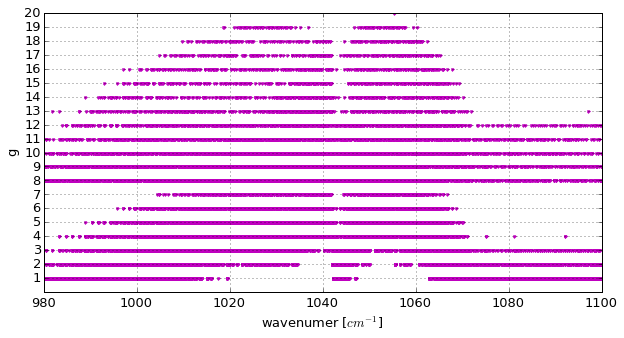

In [16]:
# plot g-group number vs wavenumber for all spectral points

ng = ng_tot()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.plot(srs_mem.index, srs_mem.values, 
        color='m', linestyle='None', marker='.')

ax.grid(b=True)

ax.set_yticks(range(1, ng + 1))
ax.set_yticklabels(range(1, ng + 1))
ax.set_ylabel('g')

ax.set_xlabel('wavenumer [$cm^{-1}$]')

In [17]:
def plt_ggroups_on_kdist(srs_l, srs_h, ncut_high):

    ng = ng_tot()

    fig, axs = plt.subplots(nrows=ng, ncols=2, figsize=(15, 3 * ng),
                        )

    for (ax_l, ax_h), g in zip(axs, range(1, ng + 1)):
    
    
        wvns_sub = ncut_high[0][ncut_high[0] == g].index
    
        ax_h.plot(srs_h.index,
                 srs_h.values,
                 color='grey',
                 linestyle='None', 
                 marker='.', markersize=.2)
    
        ax_h.plot(srs_h[wvns_sub].index,
                  srs_h[wvns_sub].values, 
                  color='r',
                  linestyle='None', 
                  marker='.', markersize=.2)
    
        ax_h.axhline(y=srs_h[wvns_sub].min(), 
                     color='r')
        ax_h.axhline(y=srs_h[wvns_sub].max(),
                     color='r')
        
        plt.setp(ax_h.get_yticklabels(), visible=False)
        ax_h.yaxis.set_tick_params(size=0)
        
    
        ax_l.plot(srs_l.index,
                 srs_l.values, 
                 color='grey',
                 linestyle='None',
                 marker='.', markersize=.2)
    
        ax_l.plot(srs_l[wvns_sub].index,
                  srs_l[wvns_sub].values,
                  color='r',
                  linestyle='None',
                  marker='.', markersize=.2)
    
        ax_l.axhline(y=srs_l[wvns_sub].min(),
                     color='r')
        ax_l.axhline(y=srs_l[wvns_sub].max(),
                     color='r')
    
    
    axs.flatten()[0].get_shared_y_axes().join(*axs.flatten())
    all([ax.set_yscale('log') == None for ax in axs.flatten()])
    
    plt.subplots_adjust(wspace=0)
    return fig, axs

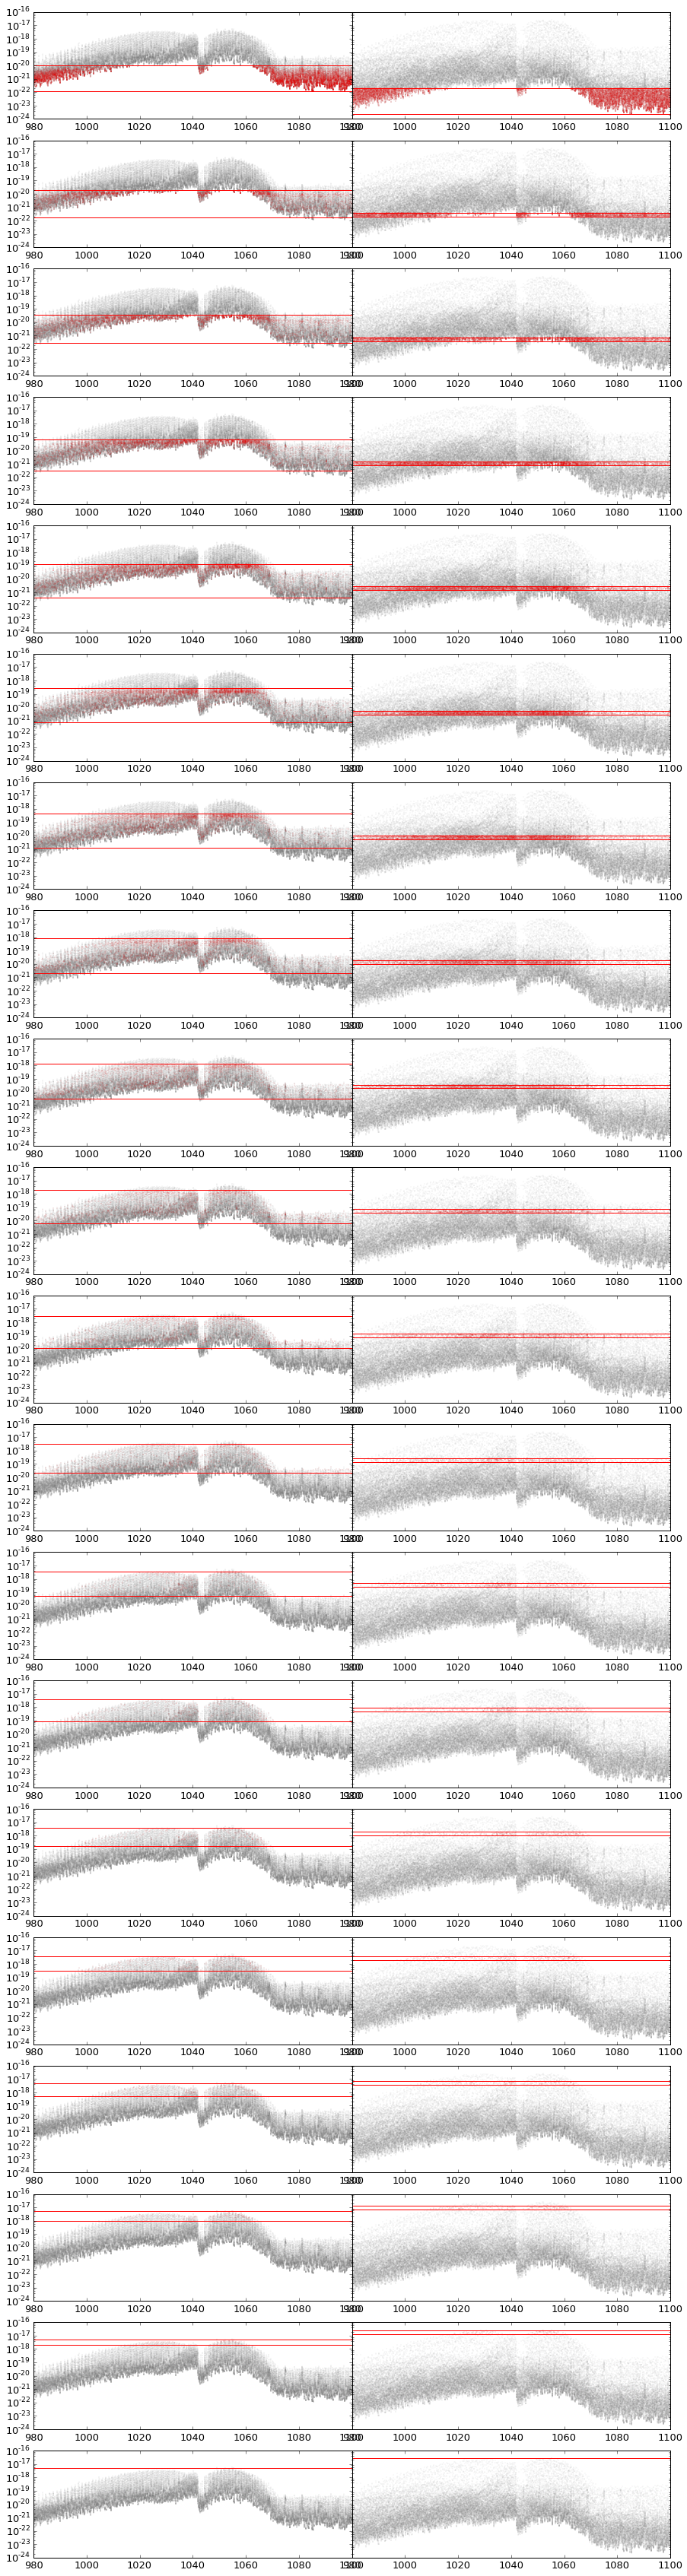

In [18]:
srs_l = df[ref_pts()['low']]
srs_h = df[ref_pts()['high']]

fig, axs = plt_ggroups_on_kdist(srs_l, srs_h, ncut_high)

In [19]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
